In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
np.set_printoptions(precision=4,suppress=True)
import scipy
import numpy as np
from scipy.linalg import toeplitz
from scipy import signal


def matrix_to_vector(input):
    """
    Converts the input matrix to a vector by stacking the rows in a specific way explained here
    
    Arg:
    input -- a numpy matrix
    
    Returns:
    ouput_vector -- a column vector with size input.shape[0]*input.shape[1]
    """
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    # flip the input matrix up-down because last row should go first
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row   
    return output_vector


def vector_to_matrix(input, output_shape):
    """
    Reshapes the output of the maxtrix multiplication to the shape "output_shape"
    
    Arg:
    input -- a numpy vector
    
    Returns:
    output -- numpy matrix with shape "output_shape"
    """
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output


def convolution_as_maultiplication(I, F, print_ir=False):
    """
    Performs 2D convolution between input I and filter F by converting the F to a toeplitz matrix and multiply it
      with vectorizes version of I
      By : AliSaaalehi@gmail.com
      
    Arg:
    I -- 2D numpy matrix
    F -- numpy 2D matrix
    print_ir -- if True, all intermediate resutls will be printed after each step of the algorithms
    
    Returns: 
    output -- 2D numpy matrix, result of convolving I with F
    """
    # number of columns and rows of the input 
    I_row_num, I_col_num = I.shape 

    # number of columns and rows of the filter
    F_row_num, F_col_num = F.shape

    #  calculate the output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    if print_ir: print('output dimension:', output_row_num, output_col_num)

    # zero pad the filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)
    if print_ir: print('F_zero_padded: ', F_zero_padded)

    # use each row of the zero-padded F to creat a toeplitz matrix. 
    #  Number of columns in this matrices are same as numbe of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :] # i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined otherwise
                                                            # the result is wrong
        toeplitz_m = toeplitz(c,r) # this function is in scipy.linalg library
        toeplitz_list.append(toeplitz_m)
        if print_ir: print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = toeplitz(c, r)
    if print_ir: print('doubly indices \n', doubly_indices)

    ## creat doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # hight and withs of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    if print_ir: print('doubly_blocked: ', doubly_blocked)

    # convert I to a vector
    vectorized_I = matrix_to_vector(I)
    if print_ir: print('vectorized_I: ', vectorized_I)
    
    # get result of the convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    if print_ir: print('result_vector: ', result_vector)

    # reshape the raw rsult to desired matrix form
    out_shape = [output_row_num, output_col_num]
    output = vector_to_matrix(result_vector, out_shape)
    if print_ir: print('Result of implemented method: \n', output)
    
    return doubly_blocked, vectorized_I, output

(64, 64, 4)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


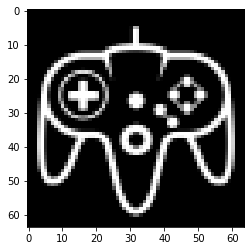

In [26]:
img_64 = imread('./game_64.png')
print(np.shape(img_64))
print(img_64[:,:,3])
img_64 = img_64[:,:,3]
plt.imshow(img_64,cmap='gray')

img1 = img_64

(64, 64, 3)


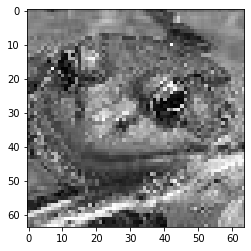

In [61]:
img_64 = imread('./fish3.jpeg')
print(np.shape(img_64))
# print(img_64[:,:,3])
# img_64 = img_64[:,:,3]

img_64 = 0.299 * img_64[:,:,0] +  0.587 * img_64[:,:,1] + 0.114 * img_64[:,:,2]
plt.imshow(img_64,cmap='gray')

img1 = img_64

(256, 256)


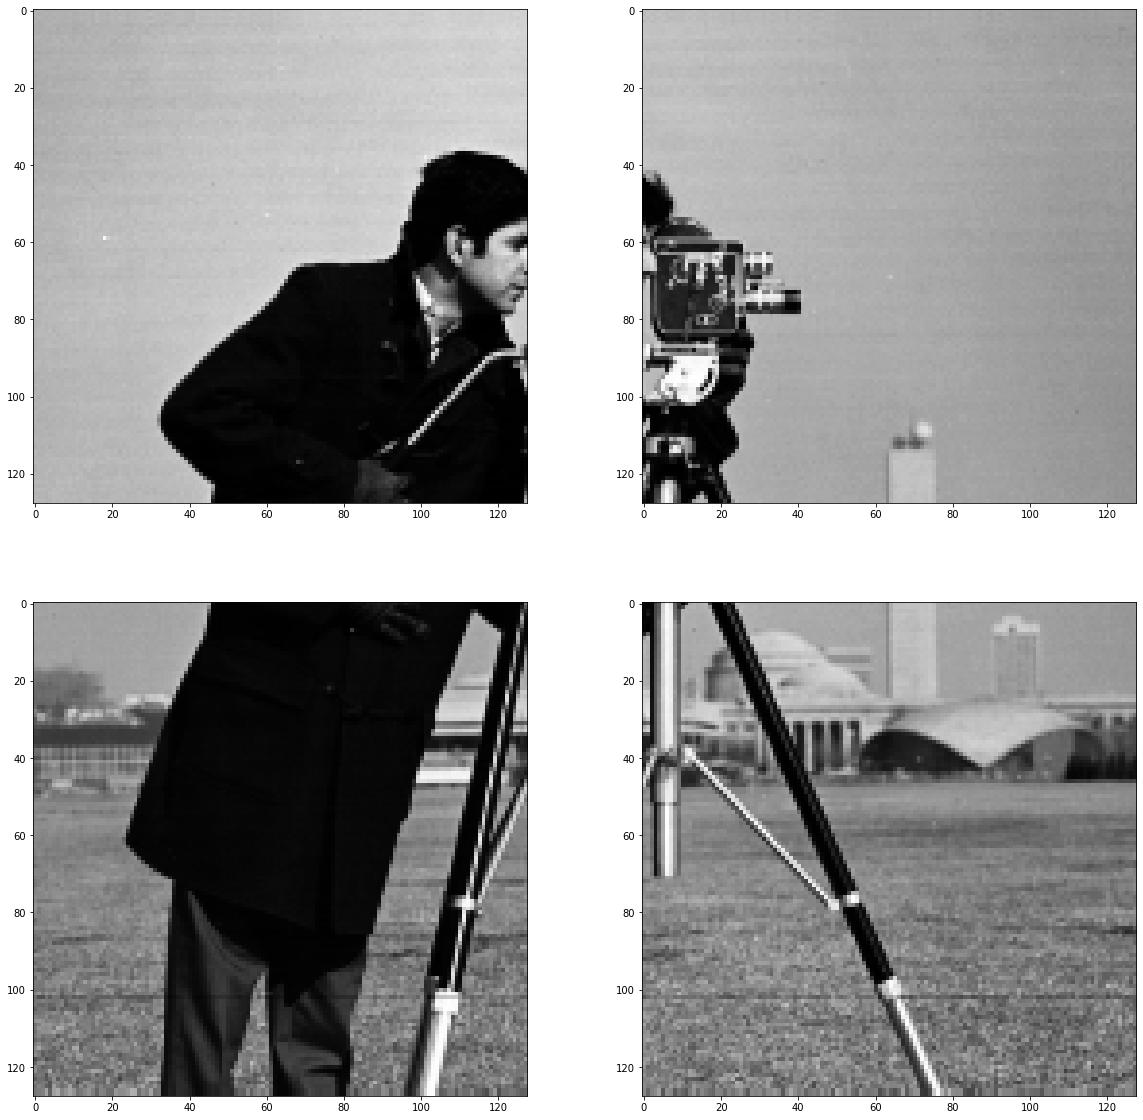

In [27]:
img = imread('./cameraman256.png')
img1 = [x[0:128] for x in img[0:128]]
img2 = [x[0:128] for x in img[128:256]]
img3 = [x[128:256] for x in img[0:128]]
img4 = [x[128:256] for x in img[128:256]]

fig,ax = plt.subplots(2,2,figsize = (20,20))
ax[0][0].imshow(img1,cmap='gray')
ax[1][0].imshow(img2,cmap='gray')
ax[0][1].imshow(img3,cmap='gray')
ax[1][1].imshow(img4,cmap='gray')
print(np.shape(img))


In [62]:
# F_array = np.eye(16384,dtype=np.float32) assume same geometric warping
N = 64
N2 = N**2

C_array = np.zeros((8,N2,N2),dtype=np.float32)
D_array = np.zeros((N2//4,N2),dtype=np.float32)
E_array = np.random.normal(0, 1, N2//4) #guassian noise

#preparing D
ct = 0
for i in range(N):
    for j in range(N):
        if i%2.0 != 0 and j%2.0 != 0:
            D_array[ct][i*N+j] = 1
            ct+=1
            
#preparing C
Filters = np.zeros((8,5,5))
Filters[0] = np.array([[0,0,1,0,0],[0,1,2,1,0],[1,2,3,2,1],[0,1,2,1,0],[0,0,1,0,0]])/19
Filters[1] = np.array([[0,0,0,0,0],[0,1,2,1,0],[0,2,4,2,0],[0,1,2,1,0],[0,0,0,0,0]])/16
Filters[2] = np.array([[0,0,0,0,0],[0,1,2,1,0],[0,2,2,2,0],[0,1,2,1,0],[0,0,0,0,0]])/14
Filters[3] = np.array([[0,0,0,0,0],[0,2,2,2,0],[0,2,2,2,0],[0,2,2,2,0],[0,0,0,0,0]])/18
Filters[4] = np.array([[0,0,1,0,0],[0,1,2,1,0],[1,2,2,2,1],[0,1,2,1,0],[0,0,1,0,0]])/18
Filters[5] = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])/25
Filters[6] = np.array([[0,1,1,1,0],[1,1,2,1,1],[1,2,4,2,1],[1,1,2,1,1],[0,1,1,1,0]])/28
Filters[7] = np.array([[0,1,1,1,0],[1,1,2,1,1],[1,2,2,2,1],[1,1,2,1,1],[0,1,1,1,0]])/26

1.3118085861206055


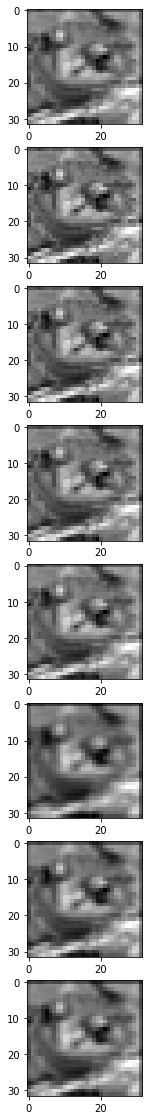

In [63]:
import time
s = time.time()
fig,ax = plt.subplots(8,figsize = (20,20))
img_blur = np.zeros((8,N2//4), dtype = np.float32)

for i in range(8):
    temp1,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filters[i])
    C_array[i] = [temp1[j] for j in range(len(temp1)) if j%68 < 66 and j//68 < 66 and j%68 > 1 and j//68 > 1]
#     C_array[i] = [temp1[j] for j in range(len(temp1)) if j%132 < 130 and j//132 < 130 and j%132 > 1 and j//132 > 1]
    temp2 = np.matmul(C_array[i],img1_vector)
    img_blur[i] = D_array @ temp2
#     asd = signal.convolve2d(img1, Filters[0], "same")
#     assert(vector_to_matrix(img1_blur1,[128,128]).all() == asd.all())
    ax[i].imshow(vector_to_matrix(img_blur[i],[N//2,N//2]),cmap='gray')
e=time.time()
print(e-s)
#     ax[i].imshow(asd,cmap='gray')
# temp1,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter1)
# temp2,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter2)
# temp3,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter3)
# temp4,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter4)
# temp5,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter5)
# temp6,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter6)
# temp7,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter7)
# temp8,img1_vector, img1_filterted = convolution_as_maultiplication(np.array(img1),Filter8)

# from scipy import signal
# lib_result = signal.convolve2d(img1, Filter1, "full")
# print('lib result: \n', lib_result)

# assert(img1_filterted.all() == lib_result.all())

# img1_vector = [x[0:128]for x in img1_vector]
# C_array[0] = [temp1[i] for i in range(len(temp1)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[1] = [temp2[i] for i in range(len(temp2)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[2] = [temp3[i] for i in range(len(temp3)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[3] = [temp4[i] for i in range(len(temp4)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[4] = [temp5[i] for i in range(len(temp5)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[5] = [temp6[i] for i in range(len(temp6)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[6] = [temp7[i] for i in range(len(temp7)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# C_array[7] = [temp8[i] for i in range(len(temp8)) if i%132 < 130 and i//132 < 130 and i%132 > 1 and i//132 > 1]
# # lib_result = signal.convolve2d(img1, Filter1, "same")
# img1_blur1 = np.matmul(temp1,img1_vector)
# img1_blur2 = np.matmul(temp2,img1_vector)
# img1_blur3 = np.matmul(temp3,img1_vector)
# img1_blur4 = np.matmul(temp4,img1_vector)
# img1_blur5 = np.matmul(temp5,img1_vector)
# img1_blur6 = np.matmul(temp6,img1_vector)
# img1_blur7 = np.matmul(temp7,img1_vector)
# img1_blur8 = np.matmul(temp8,img1_vector)
# print(np.shape(img1_vector))
# print(np.shape(temp1))
# print(np.shape(img1_filterted))
            
# assert(a.all() == lib_result.all())


# print(D_array)
# img_down = np.reshape(D_array@np.ravel(img1), (64,64))
# print(np.shape(img_down))
# fig,ax = plt.subplots(4,2,figsize = (20,20))
# ax[0][0].imshow(vector_to_matrix(img1_blur1,(128,128)),cmap='gray')
# ax[0][1].imshow(vector_to_matrix(img1_blur2,(128,128)),cmap='gray')
# ax[1][0].imshow(vector_to_matrix(img1_blur3,(128,128)),cmap='gray')
# ax[1][1].imshow(vector_to_matrix(img1_blur4,(128,128)),cmap='gray')
# ax[2][0].imshow(vector_to_matrix(img1_blur5,(128,128)),cmap='gray')
# ax[2][1].imshow(vector_to_matrix(img1_blur6,(128,128)),cmap='gray')
# ax[3][0].imshow(vector_to_matrix(img1_blur7,(128,128)),cmap='gray')
# ax[3][1].imshow(vector_to_matrix(img1_blur8,(128,128)),cmap='gray')



In [64]:
s=time.time()
R = np.zeros((N2,N2), dtype = np.float32)
for i in range(8):
    temp = D_array @ C_array[i]
    temp = D_array.T @ temp 
    temp = C_array[i].T @ temp
    print(np.shape(temp))
    R += temp
    print(i)
    
e=time.time()
print(e-s)

(4096, 4096)
0
(4096, 4096)
1
(4096, 4096)
2
(4096, 4096)
3
(4096, 4096)
4
(4096, 4096)
5
(4096, 4096)
6
(4096, 4096)
7
8.823522567749023


In [65]:
print(np.shape(C_array[i].T))
print(np.shape(D_array.T))
print(np.shape(img_blur[i]))


(4096, 4096)
(4096, 1024)
(1024,)


In [66]:
s=time.time()
P = np.zeros(N2, dtype = np.float32)
for i in range(8):
    temp = img_blur[i]
    temp = D_array.T @ temp 
    temp = C_array[i].T @ temp
    print(np.shape(temp))
    P += temp
    print(i)
        
e=time.time()
print(e-s)

(4096,)
0
(4096,)
1
(4096,)
2
(4096,)
3
(4096,)
4
(4096,)
5
(4096,)
6
(4096,)
7
0.03700971603393555


1
(2,)
(array([ 40.95  ,  73.0287,  79.6164, ..., 126.7962, 135.5527, 118.5728],
      dtype=float32), 5)
7865.0835
898651.4


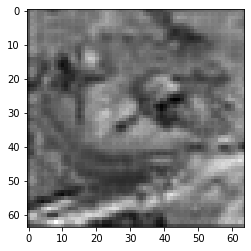

In [67]:
# X_ML = np.linalg.solve(R,P)
# X_ML = R_inv @ P.T
X_ML = scipy.sparse.linalg.cg(R,P,maxiter=5)
print('1')
print(np.shape(X_ML))
print(X_ML)
print(np.sum(R))
print(np.sum(P))
plt.imshow(vector_to_matrix(X_ML[0],(N,N)),cmap='gray')

In [68]:
error = 0
img1_restored = vector_to_matrix(X_ML[0],(N,N))
for i in range(N):
    for j in range(N):
        
        error += (img1[i][j]-img1_restored[i][j])**2
error /= (np.sum(img1_restored)*np.sum(img1))
error *= N2
print(error)


0.04029432416755094


In [69]:
iters = [1,5,10,15,20,25,30,35,50,50]
errors = []
s=time.time()

for n in range(20):
    X_ML = scipy.sparse.linalg.cg(R,P,maxiter=n)
    error = 0
    img1_restored = vector_to_matrix(X_ML[0],(N,N))
    for i in range(N):
        for j in range(N):

            error += (img1[i][j]-img1_restored[i][j])**2
    error /= (np.sum(img1_restored)*np.sum(img1))
    error *= N2
    errors.append(error)
    print(n)
    
      
e=time.time()
print(e-s)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1.1452796459197998


In [70]:
from skimage.measure import compare_ssim
iters = [1,5,10,15,20,25,30,35,50,50]
errors = []
s=time.time()

for n in range(20):
    X_ML = scipy.sparse.linalg.cg(R,P,maxiter=n)
    img1_restored = vector_to_matrix(X_ML[0],(N,N))
    (score, diff) = compare_ssim(img1_restored, np.array(img1), full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    errors.append(score)
    
      
e=time.time()
print(e-s)  

SSIM: 0.9783377038161953
SSIM: 0.5131385541275788
SSIM: 0.6574706148454789
SSIM: 0.7089421987096983
SSIM: 0.7351692265879111
SSIM: 0.7560430259848533
SSIM: 0.7767508548517691
SSIM: 0.7965297494770951
SSIM: 0.8136669378656513
SSIM: 0.8286133551949384
SSIM: 0.8426240696189059
SSIM: 0.8568321150615307
SSIM: 0.8698847147961042
SSIM: 0.879863991950251
SSIM: 0.8860047739713854
SSIM: 0.8898797909728366
SSIM: 0.8926364503316842
SSIM: 0.8951019859893351
SSIM: 0.8979430244835969
SSIM: 0.9009114667874337
1.0583138465881348


0.9009114667874337


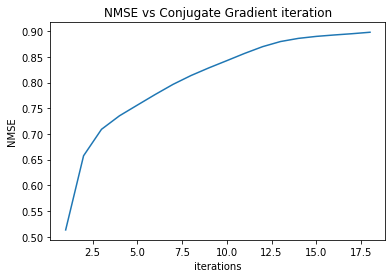

In [71]:
plt.plot(np.arange(20)[1:-1],errors[1:-1])
plt.title("NMSE vs Conjugate Gradient iteration")
plt.xlabel("iterations")
plt.ylabel("NMSE")
print(errors[-1])

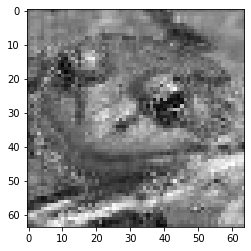

In [72]:
plt.imshow(vector_to_matrix(X_ML[0],(N,N)),cmap='gray')

In [73]:
import time
s = time.time()
X_ML = scipy.sparse.linalg.cg(R,P,maxiter=n)
e = time.time()
print(e-s)

0.056012630462646484


In [74]:
from skimage.measure import compare_ssim
img1_restored = vector_to_matrix(X_ML[0],(N,N))
(score, diff) = compare_ssim(img1_restored, np.array(img1), full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

SSIM: 0.9009114667874337
